### Mykhaylo Shumko 
I explore how well MCMC samplers with tampering can fit a superposed Gaussian envelope to real microburst data. I will use the evidence (marginalized likelihood) to calculate what number of Gaussians best fits the data assuming Poisson noise.

In [1]:
import numpy as np
import scipy.stats
import pymc3 as pm
import theano.tensor as tt
import theano
from datetime import datetime
from pymc3.math import logsumexp
import matplotlib.pyplot as plt
import dateutil.parser
#from matplotlib.ticker import MaxNLocator
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]
print('pymc3 version  = ', pm.__version__)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc3 version  =  3.5


### Load validation data

In [2]:
data_path = '/home/mike/research/ac6_microburst_scale_sizes/data/train/ac6a_training_data.csv'

#converters = {i:float for i in range(1, 19)}
#converters[0] = lambda t: dateutil.parser.parse(t)
dtypes = {i:float for i in range(1, 19)}
dtypes[0] = datetime
d = np.genfromtxt(data_path, delimiter=',', 
                  usecols=range(1, 19))

### Plot a few microbursts

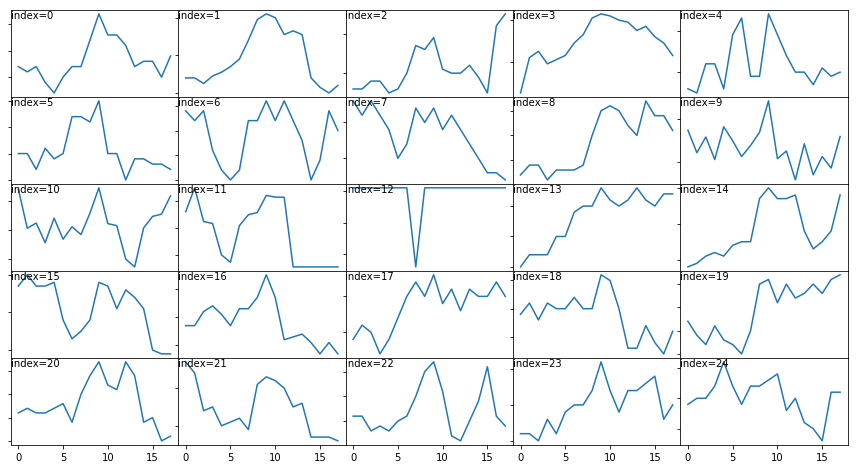

In [3]:
N_rows = 5; N_cols = 5
fig, ax = plt.subplots(N_rows, N_cols, figsize=(15, 8), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
j = 0
for _, a in np.ndenumerate(ax):
    #a.set_xticklabels([])
    a.set_yticklabels([])
    idx = np.where(d[j] >= 0)[0]
    a.plot(d[j, idx])
    a.text(0, 1, 'index={}'.format(j), transform=a.transAxes, va='top')
    j += 1

Define Gaussian function in theano (in pymc4 will be via TensorFlow).

In [4]:
def ngaus(w, mu, sd, t):
    """
    A theano tensor n-Gaussian function.
    """
    t = t.reshape((len(t), 1))
    if hasattr(w, '__len__'):
        n_p = len(w)
    else:
        n_p = 1
    #print(w.shape, x.shape, mu.shape, sd.shape)
    logp = tt.ones((len(t), n_p))*tt.log(w) + pm.Normal.dist(mu, sd).logp(t)
    print(logp.eval())
    print(tt.exp(logp).eval())
    return tt.sum(tt.exp(logp), axis=1)

x = tt.vector()
pA = tt.scalar()
pt0 = tt.scalar()
pSigma = tt.scalar()
f = theano.function([x, pA, pt0, pSigma], pA*tt.exp(-(x-pt0)**2/pSigma**2))

def ngaus2(t, A, t0, sigma):
    #print(p)
    if not hasattr(A, '__len__'):
        return f(t, A, t0, sigma)
    else:
        y = np.zeros_like(t)
        for pi in zip(A, t0, sigma): 
            y += f(t, *pi)
        return y
    
#     #p = np.array(p)
#     # If only one Gaussian, just eval function and return
#     if len(p.shape) == 1:
#         return f(t, p)
#     else:
#         y = np.zeros_like(t)
#         for pi in p: y += f(t, pi)
#     return y
    

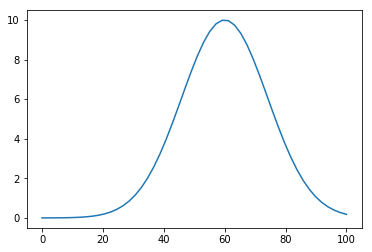

In [6]:
plt.plot(np.linspace(0, 100), ngaus2(np.linspace(0, 100), 10, 60, 20));

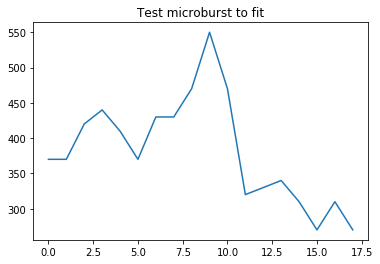

In [7]:
fit_index = 16
fit_counts = d[fit_index]
plt.plot(fit_counts); plt.title('Test microburst to fit');
t = np.arange(len(fit_counts))

In [9]:
models = {}
traces = {}
N = np.arange(1, 3)
for n_i in N:
    n_i = int(n_i)
    with pm.Model() as model:
        A_m = pm.Uniform('A', lower=0, upper=1000, shape=n_i)
        t0_m = pm.Uniform('t0', lower=0, upper=20, shape=n_i)
        sigma_m = pm.Uniform('sigma', lower=0, upper=20, shape=n_i)
        
        # background params
        #slope = pm.Uniform('slope', lower=-1000, upper=1000)
        #intercept = pm.Uniform('intercept', lower=-1000, upper=1000)
        
        # Evaluate the model and convert to counts.
        # Also add a linear trend
        #p = np.array([A_m, t0_m, sigma_m])
        #print(p[0])
        lams = ngaus2(t, A_m, t0_m, sigma_m)
        #mu = ngaus(A_m, t0_m, sigma_m, t) #+ intercept + t*slope
        
        # Likelihood
        c_m = pm.Poisson('c_m', mu=lams, observed=fit_counts)
        trace = pm.sample(int(1E4), chains=1000, step=pm.SMC())
        models[n_i] = model
        traces[n_i] = trace

TypeError: Bad input argument with name "A" to theano function with name "<ipython-input-4-7d354982abac>:20" at index 1 (0-based).  
Backtrace when that variable is created:

  File "/home/mike/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mike/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/mike/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/home/mike/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/mike/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mike/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/mike/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-7d354982abac>", line 17, in <module>
    pA = tt.scalar()
Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?

In [ ]:
models[2].marginal_likelihood

In [ ]:
tot_evidence = sum([models[key].marginal_likelihood for key in models])

fig, ax = plt.subplots()
ax.bar(N, [100*models[key].marginal_likelihood/tot_evidence for key in models]);
ax.set_yscale('log')
# ax.set_ylim((10**-3, 100))
ax.set_xlabel('Number of Gaussians'); ax.set_ylabel('Fractional Evidence (%)');
ax.xaxis.set_major_locator(MaxNLocator(integer=True))